# Mnist分类任务
网络基本构建与训练方法
torch.nn.functional 模块
nn.Module模块

# 读取Mnist数据集


In [1]:
%matplotlib inline

In [6]:
s = requests.session()
s.keep_alive = False

In [8]:
from pathlib import Path
import requests

#DATA_PATH = Path("data")
#PATH = DATA_PATH / "mnist"

#PATH.mkdir(parents=True, exist_ok=True)

#URL = "http://deeplearning.net/data/mnist/"
#FILENAME = "mnist.pkl.gz"

#if not (PATH / FILENAME).exists():
#        content = requests.get(URL + FILENAME).content
#        (PATH / FILENAME).open("wb").write(content)


In [10]:
import pickle
import gzip
with gzip.open((PATH/FILENAME).as_posix(),"rb") as f:
    ((x_train,y_train),(x_valid,y_valid),_) = pickle.load(f, encoding = "latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


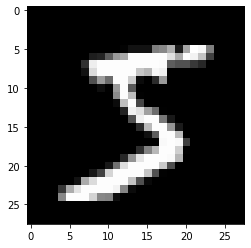

In [14]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28,28)),cmap = "gray")
print(x_train.shape)

In [15]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor,(x_train,y_train,x_valid,y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# torch.nn.functional 很多层和函数都会在这里见到
torch.nn.functional中含有很多功能，后续会常用。一般情况下，如果模型有可学习的参数，最好用nn.Module 其他情况下nn.functional相对简单一点

In [16]:
import torch.nn.functional as F
loss_func = F.cross_entropy
def model(xb):
    return xb.mm(weights) + bias

In [17]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(14.3712, grad_fn=<NllLossBackward0>)


# 创建一个model来更简化代码
必须继承nn.Module 且在其构造函数中需调用nn.Module的构造函数$\\
无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播$\\
Module中的课学习参数可以通过named_parameters()或者 parameters()返回迭代器$\\

In [18]:
from torch import nn

class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128,256)
        self.out = nn.Linear(256,10)
        
    def forward(self,x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [19]:
net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


可以打印我们定义好名字里的权重和偏置量

In [20]:
for name,parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[ 0.0341,  0.0110,  0.0148,  ...,  0.0193, -0.0234, -0.0005],
        [ 0.0054,  0.0252,  0.0202,  ...,  0.0285, -0.0047,  0.0347],
        [-0.0271,  0.0278, -0.0336,  ..., -0.0070, -0.0100, -0.0325],
        ...,
        [-0.0347, -0.0184, -0.0204,  ...,  0.0011, -0.0068,  0.0356],
        [-0.0304, -0.0282, -0.0073,  ...,  0.0304,  0.0305, -0.0172],
        [-0.0062, -0.0042,  0.0280,  ...,  0.0060,  0.0170,  0.0216]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 1.1069e-02, -4.6443e-03,  8.0656e-03,  1.7993e-02,  2.9170e-02,
         5.8220e-03, -7.4386e-03, -1.4182e-02, -3.2990e-02,  2.6046e-02,
         2.8509e-02, -2.0925e-02,  1.8690e-02,  2.9148e-02, -2.4941e-02,
         2.5654e-02,  1.6916e-02,  3.2241e-02,  1.5787e-02, -3.0654e-02,
         2.9504e-02,  2.7130e-02,  1.0985e-02,  2.7189e-02,  1.8916e-02,
        -9.4005e-03,  1.9020e-02, -1.5853e-02,  3.4862e-02, -3.2194e-02,
      

# 使用TensorDataset 和 DataLoader来简化

In [22]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle = True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size = bs* 2)

In [23]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size= bs, shuffle=True),
        DataLoader(valid_ds,batch_size = bs *2),
    )


一般在训练模型时加上model.train(),这样会正常使用Batch Normalization 和Dropout
测试的时候一般选择model.eval(),这样就不会使用Batch Normalization 和 Dropout


In [24]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) /np.sum(nums)
        print('当前step:'+str(step),'验证集损失：'+str(val_loss))


In [25]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr = 0.001)


In [26]:
def loss_batch(model, loss_func, xb, yb, opt = None):
    loss = loss_func(model(xb),yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)


In [27]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt =get_model()
fit(25,model,loss_func, opt,train_dl, valid_dl)


当前step:0 验证集损失：2.278326903152466
当前step:1 验证集损失：2.244901566696167
当前step:2 验证集损失：2.1941456745147705
当前step:3 验证集损失：2.111106593322754
当前step:4 验证集损失：1.9778085941314698
当前step:5 验证集损失：1.780006621170044
当前step:6 验证集损失：1.5291592222213746
当前step:7 验证集损失：1.2778354616165162
当前step:8 验证集损失：1.0736648317337036
当前step:9 验证集损失：0.9232409603118896
当前step:10 验证集损失：0.813596106338501
当前step:11 验证集损失：0.731258726978302
当前step:12 验证集损失：0.667184289264679
当前step:13 验证集损失：0.6167958295822143
当前step:14 验证集损失：0.5752523943901062
当前step:15 验证集损失：0.541217329454422
当前step:16 验证集损失：0.512826971244812
当前step:17 验证集损失：0.48907250604629515
当前step:18 验证集损失：0.4687370072364807
当前step:19 验证集损失：0.45105227928161623
当前step:20 验证集损失：0.436068651342392
当前step:21 验证集损失：0.42317190113067626
当前step:22 验证集损失：0.4112448613643646
当前step:23 验证集损失：0.4007654628753662
当前step:24 验证集损失：0.39168376955986023
